In [1]:
import pandas as pd
import os
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
scenario_name = 'Seattle'
out_scenario_name = 'Seattle_2050'
file_path = '/Users/xiaodanxu/Documents/SynthFirm.nosync'
parameter_dir = 'SynthFirm_parameters'
input_dir = 'inputs_' + scenario_name
output_dir = 'outputs_' + out_scenario_name

us_ton_to_ton = 0.907185
miles_to_km = 1.60934

# define output file
export_with_firm_file = 'export_OD_with_seller.csv'
import_with_firm_file = 'import_OD_with_buyer.csv'

import_file = 'import_od.csv'
export_file = 'export_od.csv'

faf_name_lookup_file = 'FAF_NAME_LOOKUP.csv'
SCTG_name_file = 'SCTG_Groups_revised.csv'
zonal_id_file = 'zonal_id_lookup_final.csv'

int_out_dir = os.path.join(file_path, output_dir, 'international')
path_to_plot = 'plots_' + out_scenario_name

export_truck_shipment = \
read_csv(os.path.join(int_out_dir, export_with_firm_file))
import_truck_shipment = \
read_csv(os.path.join(int_out_dir, import_with_firm_file))

import_shipment_value = \
read_csv(os.path.join(file_path, output_dir, import_file))
export_shipment_value = \
read_csv(os.path.join(file_path, output_dir, export_file))

faf_name_lookup = \
    read_csv(os.path.join(file_path, parameter_dir, faf_name_lookup_file))
sctg_name_lookup = \
    read_csv(os.path.join(file_path, parameter_dir, SCTG_name_file))

zonal_id_lookup = \
    read_csv(os.path.join(file_path, input_dir, zonal_id_file))
sctg_name_lookup = sctg_name_lookup[['SCTG_Code', 'Description']]
zonal_id_lookup = zonal_id_lookup[['MESOZONE', 'FAFNAME']]

In [3]:
# load data for validation
regional_import_file = 'port/FAF_regional_import_2050.csv'
regional_export_file = 'port/FAF_regional_export_2050.csv'
port_level_import_file = 'port/port_level_import.csv'
port_level_export_file = 'port/port_level_export.csv'

regional_import = read_csv(os.path.join(file_path, input_dir, regional_import_file))
regional_export = read_csv(os.path.join(file_path, input_dir, regional_export_file))
port_level_import = read_csv(os.path.join(file_path, input_dir, port_level_import_file))
port_level_export = read_csv(os.path.join(file_path, input_dir, port_level_export_file))
regional_import.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2050,value_2050,tmiles_2050,CFS_CODE,CFS_NAME,distance,mode_def
0,801,411,411,NaN,4.0,1,NaN,1,2,1,0.000070,0.009686,0.000002,C,Canada,28.571429,Truck
1,801,411,419,NaN,4.0,1,NaN,1,2,2,0.000022,0.003096,0.000004,C,Canada,181.818182,Truck
2,801,531,41,NaN,5.0,5,NaN,1,2,7,0.000000,0.000000,0.000000,C,Canada,NaN,Parcel
3,801,531,42,NaN,5.0,5,NaN,1,2,7,0.000000,0.000000,0.000000,C,Canada,NaN,Parcel
4,801,531,49,NaN,5.0,5,NaN,1,2,7,0.000000,0.000000,0.000000,C,Canada,NaN,Parcel


In [4]:
# add variables
faf_name_lookup['FAF'] = faf_name_lookup['FAF'].astype(int)
export_truck_shipment = pd.merge(export_truck_shipment, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
export_truck_shipment = pd.merge(export_truck_shipment, 
                                 zonal_id_lookup, 
                                 left_on = 'SellerZone', 
                                 right_on = 'MESOZONE', how = 'left')
export_truck_shipment.loc[:, 'total_load'] = \
export_truck_shipment.loc[:, 'TruckLoad'] * \
export_truck_shipment.loc[:, 'shipments'] / 1000 * us_ton_to_ton # in 1000 metric tons
print('Total export truck load:')
print(export_truck_shipment.loc[:, 'total_load'].sum())
export_truck_shipment.loc[:, 'Distance'] *= miles_to_km # in km

import_truck_shipment = pd.merge(import_truck_shipment, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
import_truck_shipment = pd.merge(import_truck_shipment, 
                                 zonal_id_lookup, 
                                 left_on = 'BuyerZone', 
                                 right_on = 'MESOZONE', how = 'left')
import_truck_shipment.loc[:, 'total_load'] = \
import_truck_shipment.loc[:, 'TruckLoad'] * \
import_truck_shipment.loc[:, 'shipments'] / 1000 * us_ton_to_ton # in 1000 metric tons
print('Total import truck load:')
print(import_truck_shipment.loc[:, 'total_load'].sum())
import_truck_shipment.loc[:, 'Distance'] *= miles_to_km  # in km

import_shipment_value = pd.merge(import_shipment_value, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
import_shipment_value.loc[:, 'total_load'] =  \
import_shipment_value.loc[:, 'TruckLoad'] * \
import_shipment_value.loc[:, 'ship_count'] / 1000 * us_ton_to_ton # in 1000 metric tons

print('Total import load:')
print(import_shipment_value.loc[:, 'total_load'].sum())
export_shipment_value = pd.merge(export_shipment_value, 
                                 faf_name_lookup, on = 'FAF', how = 'left')
export_shipment_value.loc[:, 'total_load'] =  \
export_shipment_value.loc[:, 'TruckLoad'] * \
export_shipment_value.loc[:, 'ship_count'] / 1000 * us_ton_to_ton # in 1000 metric tons

import_shipment_value = pd.merge(import_shipment_value, 
                                 sctg_name_lookup, on = 'SCTG_Code', how = 'left')

export_shipment_value = pd.merge(export_shipment_value, 
                                 sctg_name_lookup, on = 'SCTG_Code', how = 'left')

print('Total export load:')
print(export_shipment_value.loc[:, 'total_load'].sum())

Total export truck load:
65281.04599805317
Total import truck load:
24352.668723604398
Total import load:
41949.07965182806
Total export load:
152289.04458912578


In [5]:
export_truck_shipment = pd.merge(export_truck_shipment, 
                                 sctg_name_lookup, 
                                 left_on = 'Commodity_SCTG',
                                 right_on = 'SCTG_Code', how = 'left')

import_truck_shipment = pd.merge(import_truck_shipment, 
                                 sctg_name_lookup, 
                                 left_on = 'Commodity_SCTG',
                                 right_on = 'SCTG_Code', how = 'left')

import_truck_shipment.head(5)

,PORTID,CBP Port Location,FAF,CBPZONE,PORTZONE,TYPE,is_airport,CFS_CODE,CFS_NAME,dms_dest,...,bundle_id,BuyerID,BuyerZone,BuyerNAICS,SHORTNAME,MESOZONE,FAFNAME,total_load,SCTG_Code,Description
0,"Friday Harbor, WA","Friday Harbor, WA (Port)",539,53055,530559604002,Airport,1,A,Asia & Oceania,50,...,1,248876.0,20008.0,532A00,Rest of WA,20008,Arkansas,0.018871,30,"Textiles, Leather, and Articles of Textiles or..."
1,"Friday Harbor, WA","Friday Harbor, WA (Port)",539,53055,530559604002,Airport,1,A,Asia & Oceania,61,...,2,6666688.0,20009.0,550000,Rest of WA,20009,Los Angeles,0.000117,35,Electronic and Other Electrical Equipment and ...
2,"Friday Harbor, WA","Friday Harbor, WA (Port)",539,53055,530559604002,Airport,1,A,Asia & Oceania,61,...,3,596241.0,20009.0,424900,Rest of WA,20009,Los Angeles,0.022129,36,Motorized and Other Vehicles (includes parts)
3,"Friday Harbor, WA","Friday Harbor, WA (Port)",539,53055,530559604002,Airport,1,A,Asia & Oceania,63,...,4,8305363.0,20011.0,541512,Rest of WA,20011,San Diego,0.000037,35,Electronic and Other Electrical Equipment and ...
4,"Friday Harbor, WA","Friday Harbor, WA (Port)",539,53055,530559604002,Airport,1,A,Asia & Oceania,64,...,5,6723304.0,20012.0,561300,Rest of WA,20012,San Francisco,0.000117,35,Electronic and Other Electrical Equipment and ...


In [6]:
#summarize FAF results
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

regional_export.loc[:, 'mode_def'] = regional_export.loc[:, 'dms_mode'].map(mode_lookup)

regional_export = \
regional_export.loc[regional_export['mode_def'] != 'Other']

regional_import.loc[:, 'mode_def'] = regional_import.loc[:, 'dms_mode'].map(mode_lookup)

regional_import = \
regional_import.loc[regional_import['mode_def'] != 'Other']
regional_export.head(5)


,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2050,value_2050,tmiles_2050,CFS_CODE,CFS_NAME,distance,mode_def
0,NaN,11,531,801.0,NaN,4,4.0,1,3,8,0.000112,0.000773,0.000234,C,Canada,2089.285714,Air
1,NaN,11,539,801.0,NaN,1,1.0,1,3,8,0.000000,0.000000,0.000000,C,Canada,NaN,Truck
2,NaN,11,539,801.0,NaN,4,4.0,1,3,8,0.000000,0.000000,0.000000,C,Canada,NaN,Air
3,NaN,12,539,801.0,NaN,1,1.0,1,3,8,0.000000,0.000000,0.000000,C,Canada,NaN,Truck
4,NaN,12,539,801.0,NaN,4,4.0,1,3,8,0.000000,0.000000,0.000000,C,Canada,NaN,Air


In [7]:
analysis_year = '2050'
load_attr = 'tons_' + analysis_year

faf_export_by_zone_and_mode = \
regional_export.groupby(['dms_dest', 'mode_def'])[[load_attr]].sum()
faf_export_by_zone_and_mode = faf_export_by_zone_and_mode.reset_index()
faf_export_by_zone_and_mode.loc[:, load_attr] *= us_ton_to_ton
faf_export_by_zone_and_mode = \
pd.pivot_table(faf_export_by_zone_and_mode, index = 'dms_dest',
               columns = 'mode_def', values = load_attr, aggfunc = 'sum')
faf_export_by_zone_and_mode.loc[:, 'Total'] = \
faf_export_by_zone_and_mode.sum(axis = 1)
faf_export_by_zone_and_mode.loc['Total'] =\
faf_export_by_zone_and_mode.sum()
faf_export_by_zone_and_mode

mode_def,Air,Parcel,Rail,Truck,Total
dms_dest,,,,,
411,0.327114,77.984464,2710.264033,17130.557689,19919.133300
531,32.707902,7586.146655,4327.283264,25685.465809,37631.603629
532,0.058093,1078.491854,49712.600064,1213.796188,52004.946200
539,18.548772,5063.124457,2016.502406,20139.514414,27237.690049
Total,51.641881,13805.747430,58766.649767,64169.334100,136793.373178


In [8]:
faf_import_by_zone_and_mode = \
regional_import.groupby(['dms_orig', 'mode_def'])[[load_attr]].sum()
faf_import_by_zone_and_mode = faf_import_by_zone_and_mode.reset_index()
faf_import_by_zone_and_mode.loc[:, load_attr] *= us_ton_to_ton
faf_import_by_zone_and_mode = \
pd.pivot_table(faf_import_by_zone_and_mode, index = 'dms_orig',
               columns = 'mode_def', values = load_attr, 
               aggfunc = 'sum')
faf_import_by_zone_and_mode.loc[:, 'Total'] = \
faf_import_by_zone_and_mode.sum(axis = 1)
faf_import_by_zone_and_mode.loc['Total'] =\
faf_import_by_zone_and_mode.sum()
faf_import_by_zone_and_mode

mode_def,Air,Parcel,Rail,Truck,Total
dms_orig,,,,,
411,3.946007,46.012816,304.544616,5970.215055,6324.718495
531,39.324615,3001.426093,2482.061145,17088.120094,22610.931948
532,0.000033,6.381542,769.196397,603.352690,1378.930662
539,42.427461,856.561013,10113.526212,6786.881840,17799.396527
Total,85.698116,3910.381465,13669.328370,30448.569680,48113.977631


In [9]:
import_shipment_by_zm = \
import_shipment_value.groupby('FAF')['total_load'].sum()

print(import_shipment_by_zm.head(5))

export_shipment_by_zm = \
export_shipment_value.groupby('FAF')['total_load'].sum()

print(export_shipment_by_zm.head(5))

FAF
411     1961.564232
531    22584.612618
532     1242.530095
539    16160.372708
Name: total_load, dtype: float64
FAF
411    20454.519027
531    63396.953809
532    29046.010063
539    39391.561690
Name: total_load, dtype: float64


In [10]:
#truck only 
import_truck_by_zm = \
import_truck_shipment.groupby('FAF')['total_load'].sum()

print(import_truck_by_zm.head(5))

export_truck_by_zm = \
export_truck_shipment.groupby('FAF')['total_load'].sum()

print(export_truck_by_zm.head(5))

FAF
411     1379.629673
531    17055.701827
532      796.830538
539     5120.506685
Name: total_load, dtype: float64
FAF
411     9824.028854
531    29247.547549
532    12150.613021
539    14058.856574
Name: total_load, dtype: float64


# Part 1 -- Describe total value at each port

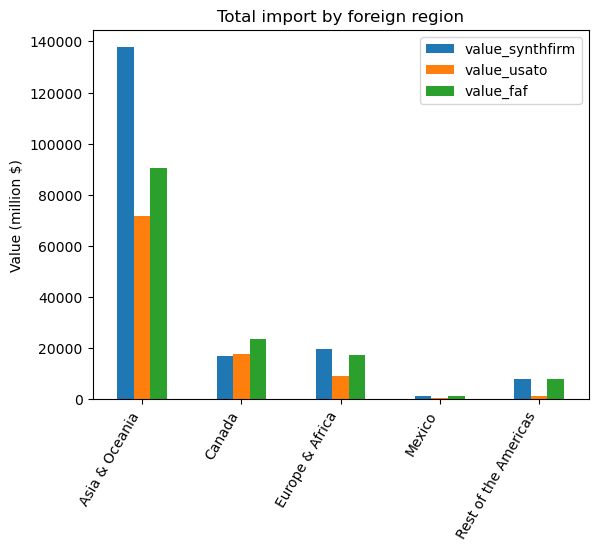

In [12]:
# region total
value_attr = 'value_' + analysis_year
# Compare import by foreign region
usato_import_by_cfs = \
port_level_import.groupby('CFS_NAME')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_cfs = usato_import_by_cfs.reset_index()

usato_import_by_cfs['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_cfs.columns = ['CFS_NAME', 'value_usato']
faf_import_agg = \
regional_import.groupby('CFS_NAME')[[value_attr]].sum()
faf_import_agg = faf_import_agg.reset_index()
faf_import_agg.columns = ['CFS_NAME', 'value_faf']

modeled_import_by_cfs = \
import_shipment_value.groupby(['CFS_NAME'])[['value_2017']].sum()

modeled_import_by_cfs = modeled_import_by_cfs.reset_index()
modeled_import_by_cfs.columns = ['CFS_NAME', 'value_synthfirm']
import_value_compare = pd.merge(modeled_import_by_cfs,
                               usato_import_by_cfs, on = 'CFS_NAME',
                               how = 'left')

import_value_compare = pd.merge(import_value_compare,
                               faf_import_agg, on = 'CFS_NAME',
                               how = 'left')
# import_value_compare = import_value_compare.drop(columns = ['dms_orig'])
import_value_compare.plot(x = 'CFS_NAME', kind = 'bar')
plt.title('Total import by foreign region')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_foreign_region.png'),
           dpi = 300, bbox_inches = 'tight')

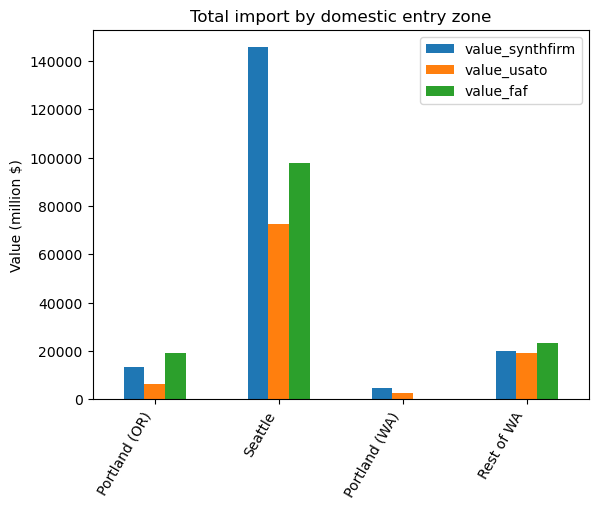

In [13]:
# Compare import by domestic entry
usato_import_by_faf = \
port_level_import.groupby('FAF')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_faf = usato_import_by_faf.reset_index()

usato_import_by_faf['Customs Value (Gen) ($US)'] /= 10 ** 6
usato_import_by_faf.columns = ['dms_orig', 'value_usato']
faf_import_agg = \
regional_import.groupby('dms_orig')[[value_attr]].sum()
faf_import_agg = faf_import_agg.reset_index()
faf_import_agg.columns = ['dms_orig', 'value_faf']

modeled_import_by_faf = \
import_shipment_value.groupby(['FAF', 'SHORTNAME'])[['value_2017']].sum()

modeled_import_by_faf = modeled_import_by_faf.reset_index()
modeled_import_by_faf.columns = ['dms_orig', 'region_name', 'value_synthfirm']
import_value_compare = pd.merge(modeled_import_by_faf,
                               usato_import_by_faf, on = 'dms_orig',
                               how = 'left')

import_value_compare = pd.merge(import_value_compare,
                               faf_import_agg, on = 'dms_orig',
                               how = 'left')
import_value_compare = import_value_compare.drop(columns = ['dms_orig'])
import_value_compare.plot(x = 'region_name', kind = 'bar')
plt.title('Total import by domestic entry zone')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_domestic_entry.png'),
           dpi = 300, bbox_inches = 'tight')

In [13]:
import_value_compare.sum()

region_name        SacramentoSan FranciscoFresnoRest of CA
value_synthfirm                               70718.338631
value_usato                                    80103.50571
value_faf                                      68380.34919
dtype: object

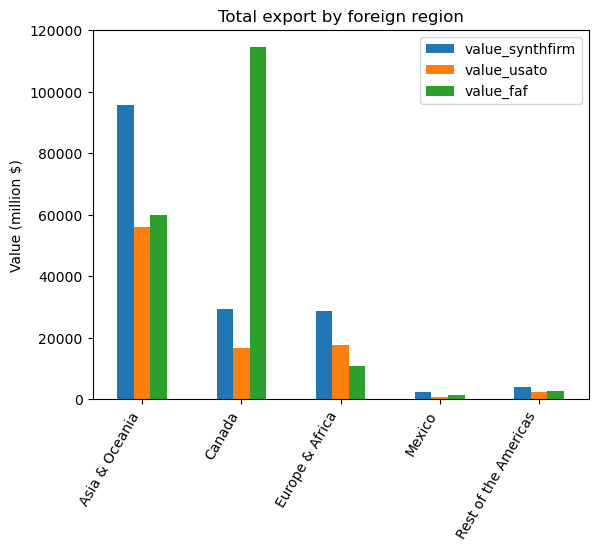

In [14]:
# Compare export by foreign region
usato_export_by_cfs = \
port_level_export.groupby('CFS_NAME')[['Total Exports Value ($US)']].sum()
usato_export_by_cfs = usato_export_by_cfs.reset_index()

usato_export_by_cfs['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_cfs.columns = ['CFS_NAME', 'value_usato']
faf_export_agg = \
regional_export.groupby('CFS_NAME')[[value_attr]].sum()
faf_export_agg = faf_export_agg.reset_index()
faf_export_agg.columns = ['CFS_NAME', 'value_faf']

modeled_export_by_cfs = \
export_shipment_value.groupby(['CFS_NAME'])[['value_2017']].sum()

modeled_export_by_cfs = modeled_export_by_cfs.reset_index()
modeled_export_by_cfs.columns = ['CFS_NAME', 'value_synthfirm']
export_value_compare = pd.merge(modeled_export_by_cfs,
                               usato_export_by_cfs, on = 'CFS_NAME',
                               how = 'left')

export_value_compare = pd.merge(export_value_compare,
                               faf_export_agg, on = 'CFS_NAME',
                               how = 'left')

export_value_compare.plot(x = 'CFS_NAME', kind = 'bar')
plt.title('Total export by foreign region')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_foreign_region.png'),
           dpi = 300, bbox_inches = 'tight')

In [15]:
export_value_compare.sum()

CFS_NAME           Asia & OceaniaCanadaEurope & AfricaMexicoRest ...
value_synthfirm                                         53172.376593
value_usato                                             54619.908016
value_faf                                               53964.952788
dtype: object

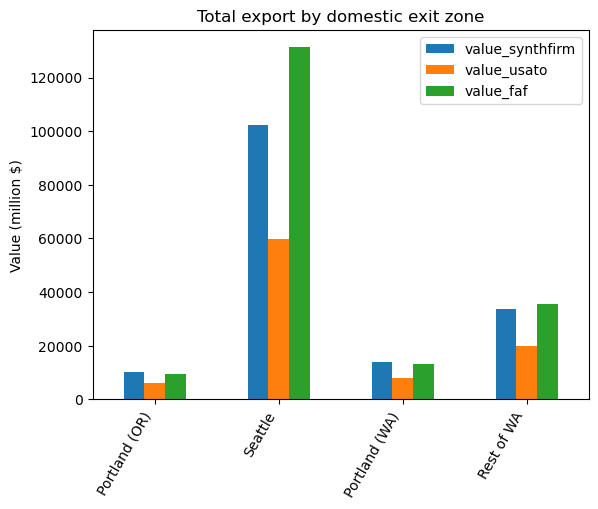

In [15]:
# Compare export by domestic exit
usato_export_by_faf = \
port_level_export.groupby('FAF')[['Total Exports Value ($US)']].sum()
usato_export_by_faf = usato_export_by_faf.reset_index()

usato_export_by_faf['Total Exports Value ($US)'] /= 10 ** 6
usato_export_by_faf.columns = ['dms_dest', 'value_usato']
faf_export_agg = \
regional_export.groupby('dms_dest')[[value_attr]].sum()
faf_export_agg = faf_export_agg.reset_index()
faf_export_agg.columns = ['dms_dest', 'value_faf']

modeled_export_by_faf = \
export_shipment_value.groupby(['FAF', 'SHORTNAME'])[['value_2017']].sum()

modeled_export_by_faf = modeled_export_by_faf.reset_index()
modeled_export_by_faf.columns = ['dms_dest', 'region_name', 'value_synthfirm']
export_value_compare = pd.merge(modeled_export_by_faf,
                               usato_export_by_faf, on = 'dms_dest',
                               how = 'left')

export_value_compare = pd.merge(export_value_compare,
                               faf_export_agg, on = 'dms_dest',
                               how = 'left')
export_value_compare = export_value_compare.drop(columns = ['dms_dest'])
export_value_compare.plot(x = 'region_name', kind = 'bar')
plt.title('Total export by domestic exit zone')
plt.ylabel('Value (million $)')
plt.xlabel('')
plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_domestic_exit.png'),
           dpi = 300, bbox_inches = 'tight')

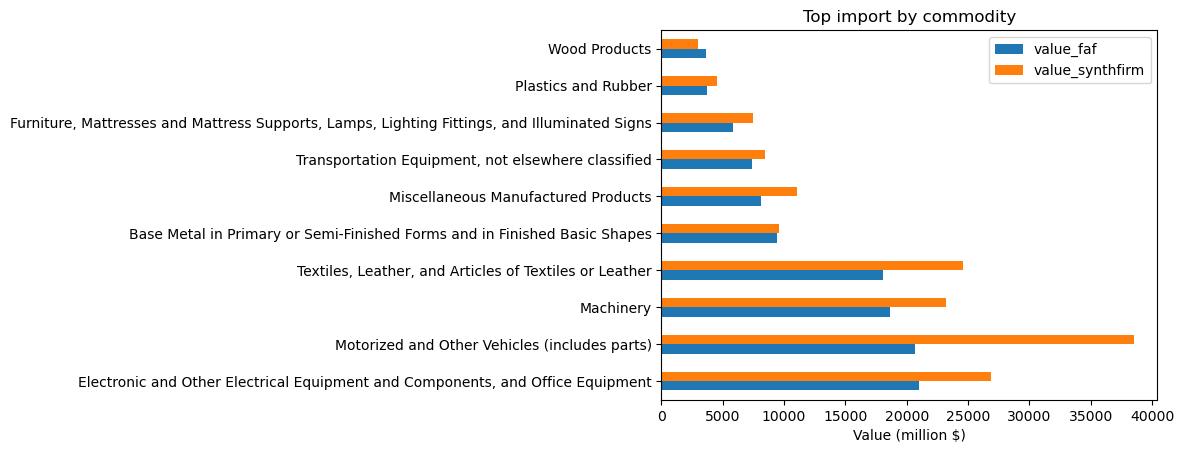

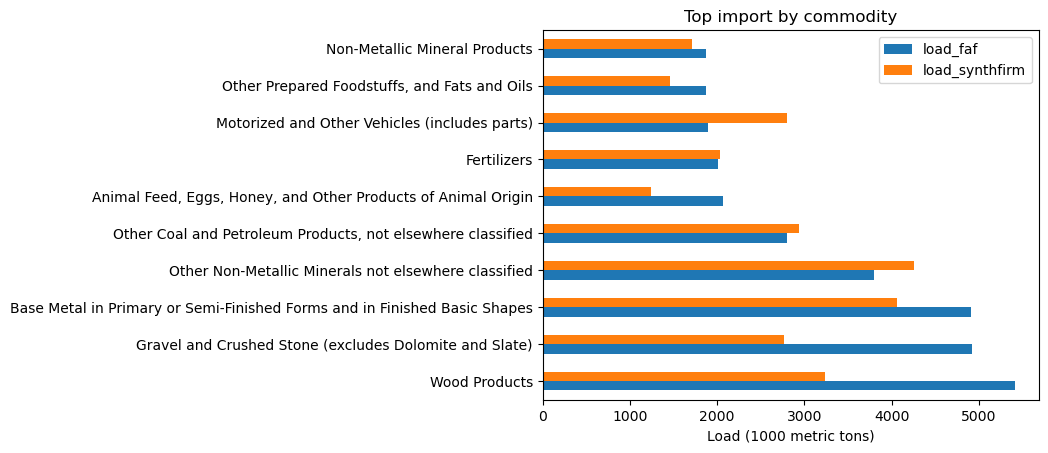

In [17]:
# top 10 import commodity by value and weight

faf_import_by_sctg = \
regional_import.groupby('sctg2')[[value_attr, load_attr]].sum()
faf_import_by_sctg = faf_import_by_sctg.reset_index()
faf_import_by_sctg.loc[:, load_attr] *= us_ton_to_ton
faf_import_by_sctg.columns = ['SCTG_Code', 'value_faf', 'load_faf']

modeled_import_by_sctg = \
import_shipment_value.groupby(['SCTG_Code', 'Description'])[['value_2017',  'total_load']].sum()

modeled_import_by_sctg = modeled_import_by_sctg.reset_index()
modeled_import_by_sctg.columns = ['SCTG_Code', 'commodity', 
                                  'value_synthfirm', 'load_synthfirm']
import_value_compare = pd.merge(faf_import_by_sctg,
                               modeled_import_by_sctg, on = 'SCTG_Code',
                               how = 'left')
import_value_compare.dropna(inplace = True)
import_value_compare.drop(columns = ['SCTG_Code'], inplace = True)

# plot value
import_value_compare = \
import_value_compare.sort_values(by = 'value_faf', ascending = False)
import_value_to_plot = import_value_compare.head(10)
import_value_to_plot = \
import_value_to_plot[['commodity', 'value_faf', 'value_synthfirm']]
import_value_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top import by commodity')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_sctg_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
import_value_compare = \
import_value_compare.sort_values(by = 'load_faf', ascending = False)
import_load_to_plot = import_value_compare.head(10)
import_load_to_plot = \
import_load_to_plot[['commodity', 'load_faf', 'load_synthfirm']]
import_load_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top import by commodity')
plt.xlabel('Load (1000 metric tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_sctg_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

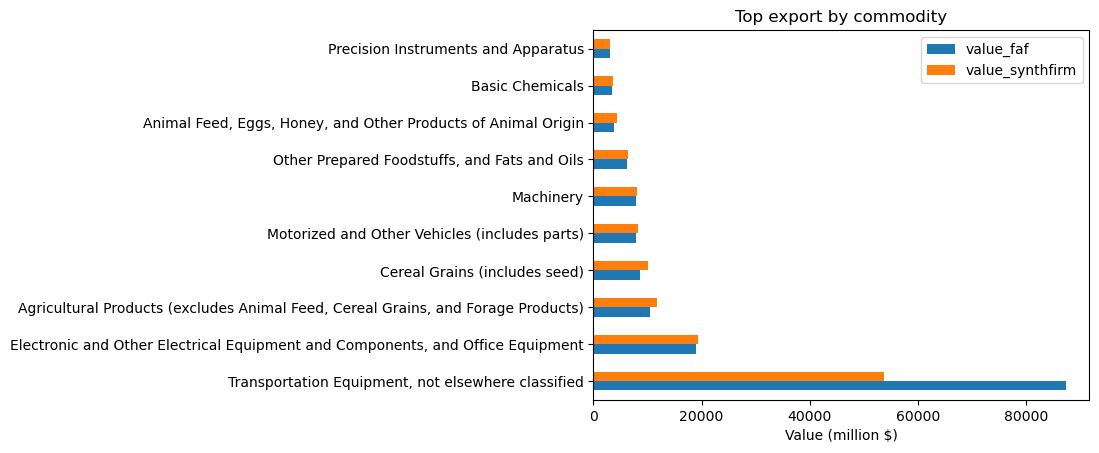

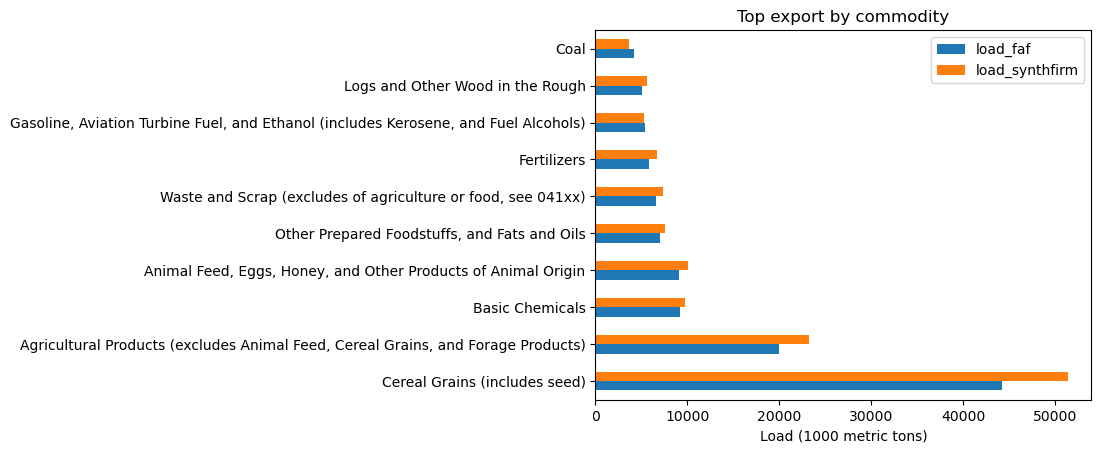

In [18]:
# top 10 export commodity by value and weight

faf_export_by_sctg = \
regional_export.groupby('sctg2')[[value_attr, load_attr]].sum()
faf_export_by_sctg = faf_export_by_sctg.reset_index()
faf_export_by_sctg.loc[:, load_attr] *= us_ton_to_ton
faf_export_by_sctg.columns = ['SCTG_Code', 'value_faf', 'load_faf']

modeled_export_by_sctg = \
export_shipment_value.groupby(['SCTG_Code', 'Description'])[['value_2017',  'total_load']].sum()

modeled_export_by_sctg = modeled_export_by_sctg.reset_index()
modeled_export_by_sctg.columns = ['SCTG_Code', 'commodity', 
                                  'value_synthfirm', 'load_synthfirm']
export_value_compare = pd.merge(faf_export_by_sctg,
                               modeled_export_by_sctg, on = 'SCTG_Code',
                               how = 'left')

export_value_compare = export_value_compare.drop(columns = ['SCTG_Code'])

# plot value
export_value_compare = \
export_value_compare.sort_values(by = 'value_faf', ascending = False)
export_value_to_plot = export_value_compare.head(10)
export_value_to_plot = \
export_value_to_plot[['commodity', 'value_faf', 'value_synthfirm']]
export_value_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top export by commodity')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_sctg_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
export_value_compare = \
export_value_compare.sort_values(by = 'load_faf', ascending = False)
export_load_to_plot = export_value_compare.head(10)
export_load_to_plot = \
export_load_to_plot[['commodity', 'load_faf', 'load_synthfirm']]
export_load_to_plot.plot(x = 'commodity', kind = 'barh')
plt.title('Top export by commodity')
plt.xlabel('Load (1000 metric tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_sctg_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

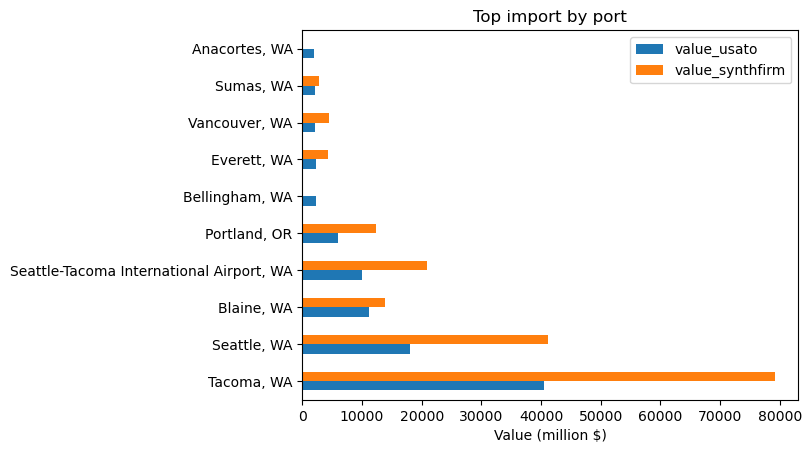

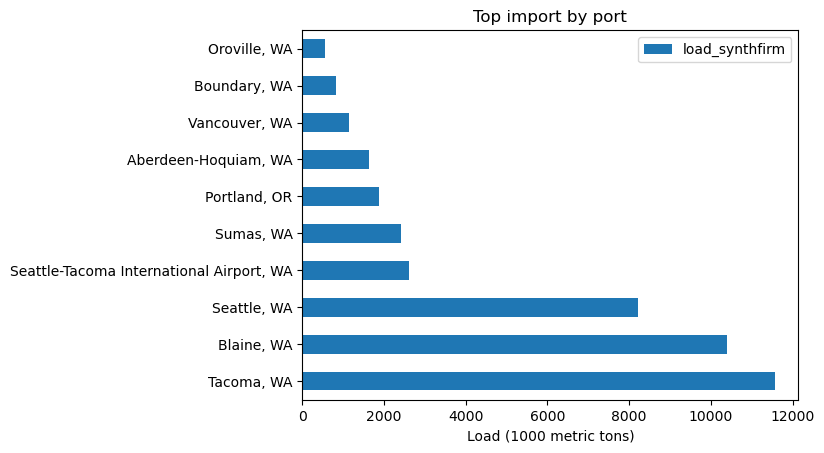

In [19]:
# top 10 import port by value and weight

usato_import_by_port = \
port_level_import.groupby('PORTID')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_port = usato_import_by_port.reset_index()
usato_import_by_port['Customs Value (Gen) ($US)'] /= 10 ** 6 # convert to million
usato_import_by_port.columns = ['PORTID', 'value_usato']

modeled_import_by_port = \
import_shipment_value.groupby(['PORTID'])[['value_2017', 'total_load']].sum()

modeled_import_by_port = modeled_import_by_port.reset_index()
modeled_import_by_port.columns = ['PORTID', 
                                  'value_synthfirm', 'load_synthfirm']
import_value_compare = pd.merge(usato_import_by_port,
                               modeled_import_by_port, on = 'PORTID',
                               how = 'left')

# plot value
import_value_compare = \
import_value_compare.sort_values(by = 'value_usato', ascending = False)
import_value_to_plot = import_value_compare.head(10)
import_value_to_plot = \
import_value_to_plot[['PORTID', 'value_usato', 'value_synthfirm']]
import_value_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top import by port')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_port_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
import_value_compare = \
import_value_compare.sort_values(by = 'load_synthfirm', ascending = False)
import_load_to_plot = import_value_compare.head(10)
import_load_to_plot = \
import_load_to_plot[['PORTID', 'load_synthfirm']]
import_load_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top import by port')
plt.xlabel('Load (1000 metric tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_port_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

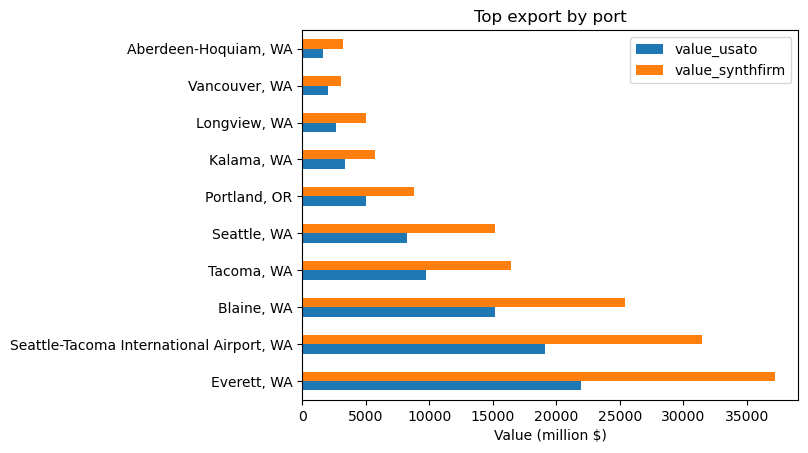

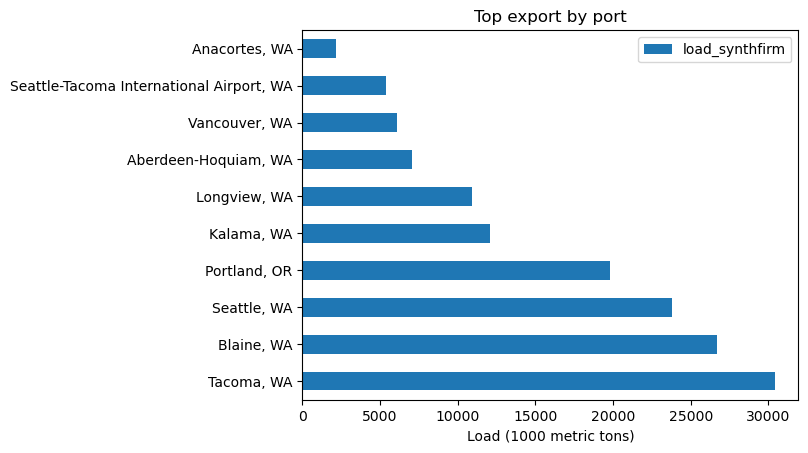

In [20]:
# top 10 export port by value and weight

usato_export_by_port = \
port_level_export.groupby('PORTID')[['Total Exports Value ($US)']].sum()
usato_export_by_port = usato_export_by_port.reset_index()
usato_export_by_port['Total Exports Value ($US)'] /= 10 ** 6 # convert to million
usato_export_by_port.columns = ['PORTID', 'value_usato']

modeled_export_by_port = \
export_shipment_value.groupby(['PORTID'])[['value_2017', 'total_load']].sum()

modeled_export_by_port = modeled_export_by_port.reset_index()
modeled_export_by_port.columns = ['PORTID', 
                                  'value_synthfirm', 'load_synthfirm']
export_value_compare = pd.merge(usato_export_by_port,
                               modeled_export_by_port, on = 'PORTID',
                               how = 'left')

# plot value
export_value_compare = \
export_value_compare.sort_values(by = 'value_usato', ascending = False)
export_value_to_plot = export_value_compare.head(10)
export_value_to_plot = \
export_value_to_plot[['PORTID', 'value_usato', 'value_synthfirm']]
export_value_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top export by port')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_port_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
export_value_compare = \
export_value_compare.sort_values(by = 'load_synthfirm', ascending = False)
export_load_to_plot = export_value_compare.head(10)
export_load_to_plot = \
export_load_to_plot[['PORTID', 'load_synthfirm']]
export_load_to_plot.plot(x = 'PORTID', kind = 'barh')
plt.title('Top export by port')
plt.xlabel('Load (1000 metric tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_port_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

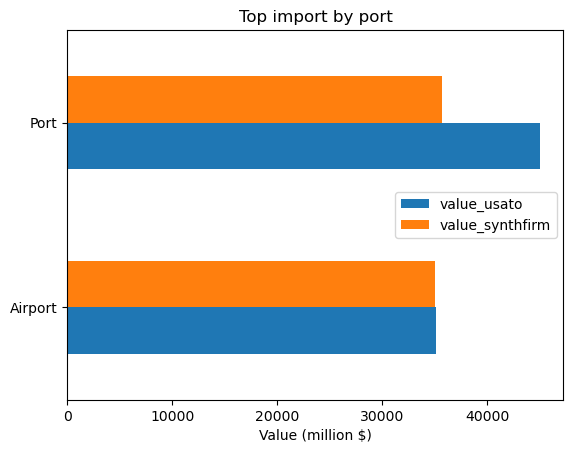

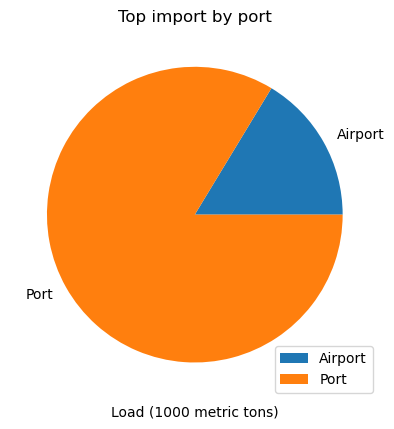

In [21]:
# total value and tonnage by type of entry

# Import plot

usato_import_by_port = \
port_level_import.groupby('TYPE')[['Customs Value (Gen) ($US)']].sum()
usato_import_by_port = usato_import_by_port.reset_index()
usato_import_by_port['Customs Value (Gen) ($US)'] /= 10 ** 6 # convert to million
usato_import_by_port.columns = ['TYPE', 'value_usato']

modeled_import_by_port = \
import_shipment_value.groupby(['TYPE'])[['value_2017', 'total_load']].sum()

modeled_import_by_port = modeled_import_by_port.reset_index()
modeled_import_by_port.columns = ['TYPE', 
                                  'value_synthfirm', 'load_synthfirm']
import_value_compare = pd.merge(usato_import_by_port,
                               modeled_import_by_port, on = 'TYPE',
                               how = 'left')

# plot value
# import_value_compare = \
# import_value_compare.sort_values(by = 'value_usato', ascending = False)
# import_value_to_plot = import_value_compare.head(10)
import_value_to_plot = \
import_value_compare[['TYPE', 'value_usato', 'value_synthfirm']]
import_value_to_plot.plot(x = 'TYPE', kind = 'barh')
plt.title('Top import by port')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_type_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
# import_value_compare = \
# import_value_compare.sort_values(by = 'load_synthfirm', ascending = False)
# import_load_to_plot = import_value_compare.head(10)
import_load_to_plot = \
import_value_compare[['TYPE', 'load_synthfirm']]
import_load_to_plot = import_load_to_plot.set_index('TYPE')
import_load_to_plot.plot(y = 'load_synthfirm', kind = 'pie')
plt.legend(loc = 4)
plt.title('Top import by port')
plt.xlabel('Load (1000 metric tons)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_import_by_type_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

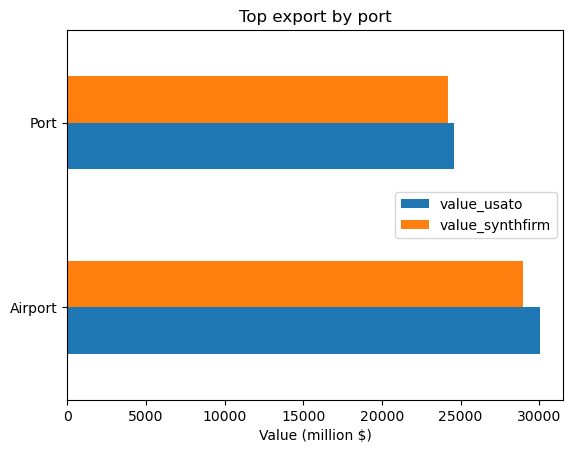

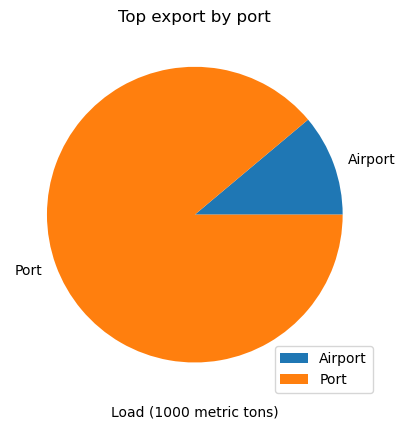

In [22]:
# Export
usato_export_by_port = \
port_level_export.groupby('TYPE')[['Total Exports Value ($US)']].sum()
usato_export_by_port = usato_export_by_port.reset_index()
usato_export_by_port['Total Exports Value ($US)'] /= 10 ** 6 # convert to million
usato_export_by_port.columns = ['TYPE', 'value_usato']

modeled_export_by_port = \
export_shipment_value.groupby(['TYPE'])[['value_2017', 'total_load']].sum()

modeled_export_by_port = modeled_export_by_port.reset_index()
modeled_export_by_port.columns = ['TYPE', 
                                  'value_synthfirm', 'load_synthfirm']
export_value_compare = pd.merge(usato_export_by_port,
                               modeled_export_by_port, on = 'TYPE',
                               how = 'left')

# plot value
# export_value_compare = \
# export_value_compare.sort_values(by = 'value_usato', ascending = False)
# export_value_to_plot = export_value_compare.head(10)
export_value_to_plot = \
export_value_compare[['TYPE', 'value_usato', 'value_synthfirm']]
export_value_to_plot.plot(x = 'TYPE', kind = 'barh')
plt.title('Top export by port')
plt.xlabel('Value (million $)')
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_type_value.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# plot load
# export_value_compare = \
# export_value_compare.sort_values(by = 'load_synthfirm', ascending = False)
# export_load_to_plot = export_value_compare.head(10)
export_load_to_plot = \
export_value_compare[['TYPE', 'load_synthfirm']]
export_load_to_plot = export_load_to_plot.set_index('TYPE')
export_load_to_plot.plot(y = 'load_synthfirm', kind = 'pie')
plt.title('Top export by port')
plt.xlabel('Load (1000 metric tons)')
plt.legend(loc = 4)
plt.ylabel('')
# plt.xticks(rotation = 60, ha = 'right')
plt.savefig(os.path.join(file_path, path_to_plot, 'top_export_by_type_load.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 2 -- OD characteristics of truck flow

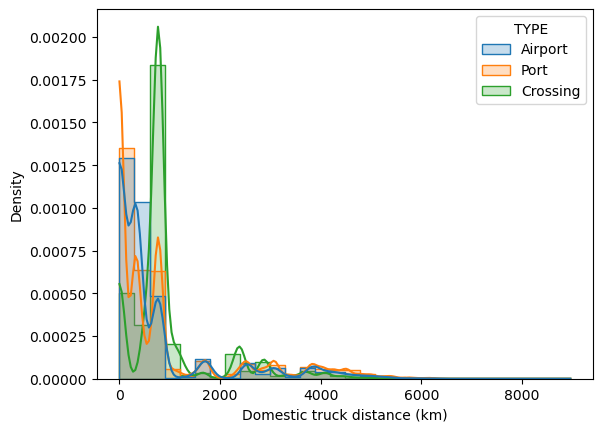

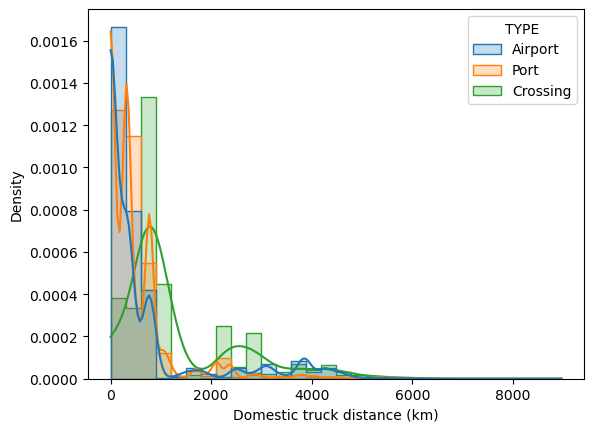

In [21]:
# plot shipment distance
sns.histplot(
   data=import_truck_shipment, x="Distance", hue="TYPE", weights = 'total_load',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic truck distance (km)')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_type_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

sns.histplot(
   data=export_truck_shipment, x="Distance", hue="TYPE", weights = 'total_load',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic truck distance (km)')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_type_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

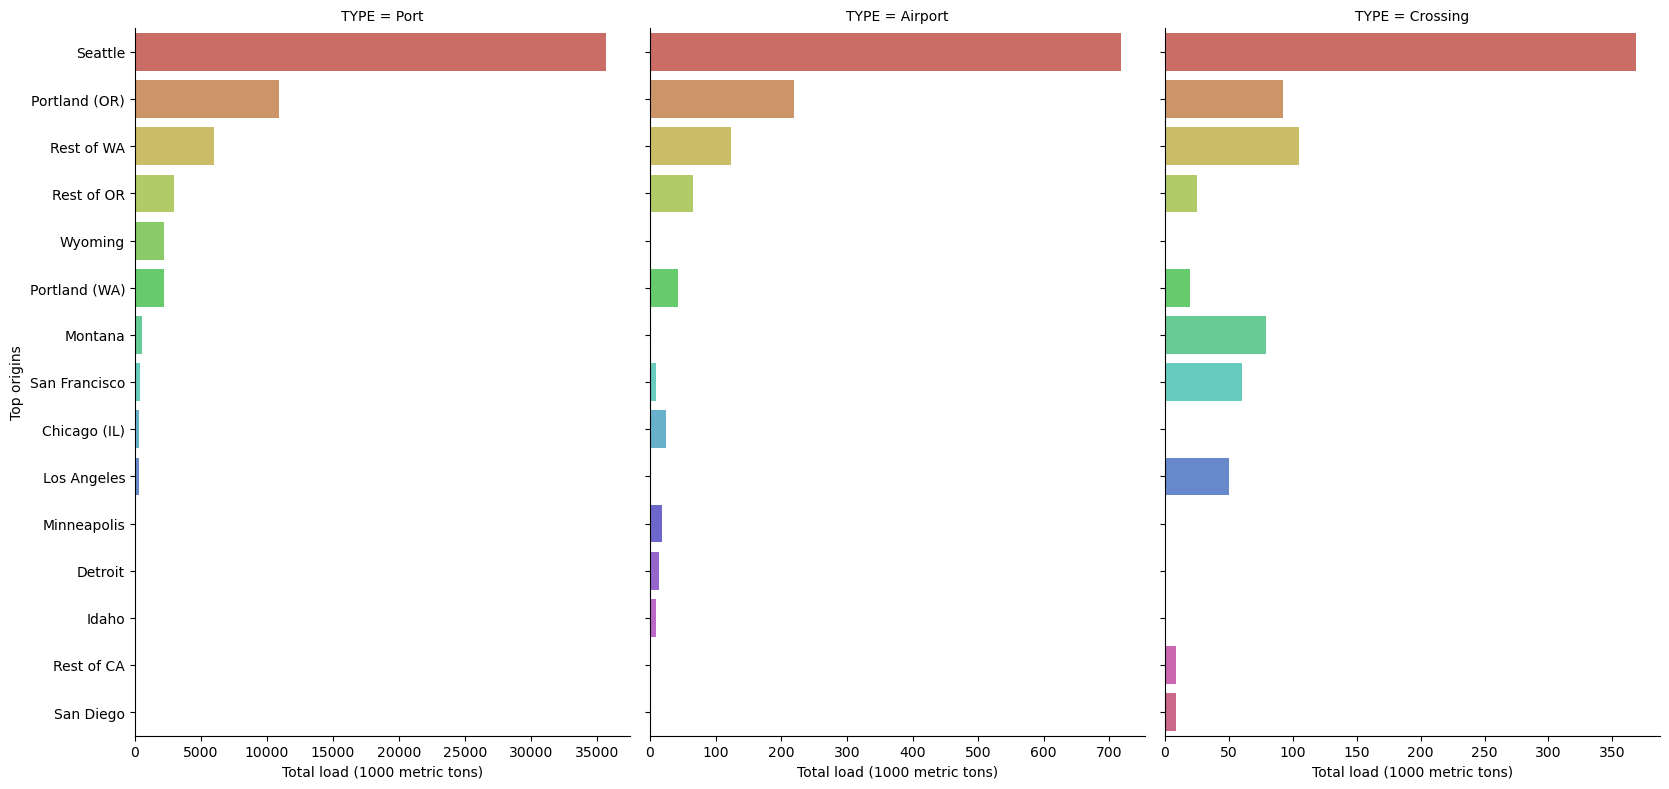

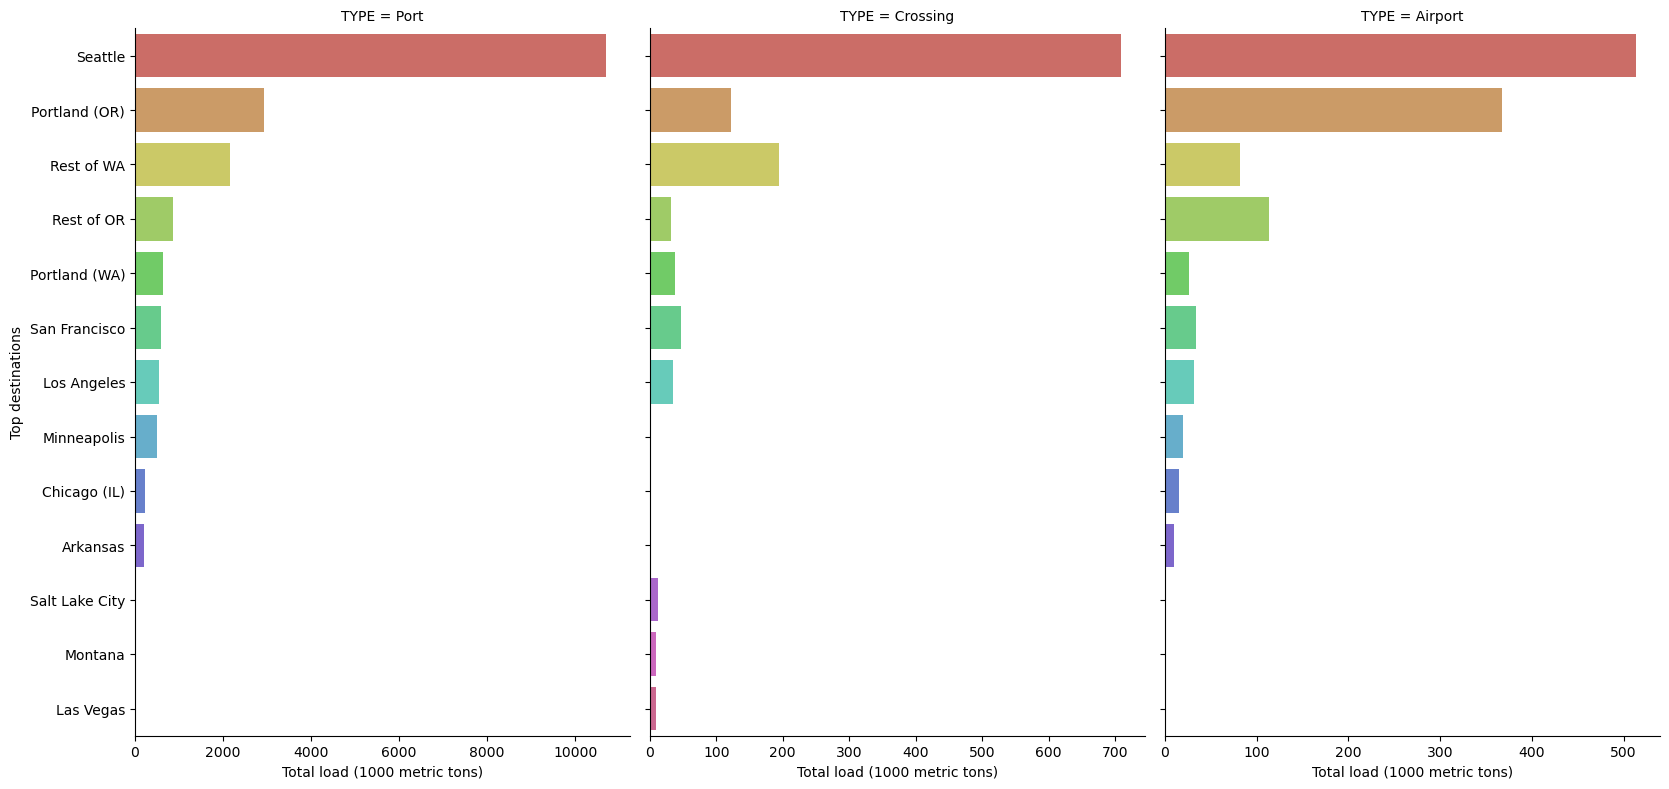

In [22]:
# top origin/destination
export_truck_origin = \
export_truck_shipment.groupby(['TYPE', 'FAFNAME'])[['total_load']].sum()
export_truck_origin = export_truck_origin.reset_index()
export_truck_origin = \
export_truck_origin.sort_values(by = 'total_load', ascending = False)

import_truck_dest = \
import_truck_shipment.groupby(['TYPE', 'FAFNAME'])[['total_load']].sum()
import_truck_dest = import_truck_dest.reset_index()
import_truck_dest = \
import_truck_dest.sort_values(by = 'total_load', ascending = False)

import_truck_dest.head(5)

export_truck_origin = export_truck_origin.groupby('TYPE').head(10)
export_truck_origin = export_truck_origin.reset_index()

ax = sns.catplot(kind = 'bar', data = export_truck_origin,
           y = 'FAFNAME', x = 'total_load', col = 'TYPE', sharex = False,
                 height=8, aspect = 0.7, palette = 'hls')
ax.set(ylabel ="Top origins")
ax.set(xlabel ="Total load (1000 metric tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_type_orig.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()
import_truck_dest = import_truck_dest.groupby('TYPE').head(10)
import_truck_dest = import_truck_dest.reset_index()

ax = sns.catplot(kind = 'bar', data = import_truck_dest,
           y = 'FAFNAME', x = 'total_load', col = 'TYPE', sharex = False,
                 height=8, aspect = 0.7, palette = 'hls')
ax.set(ylabel ="Top destinations")
ax.set(xlabel ="Total load (1000 metric tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_type_dest.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 3 -- port of SF and OAK characteristics

In [25]:
# check results for SFO and OAK

port_list = ['Oakland, CA', 'San Francisco, CA']
sf_export_truck_shipment = \
export_truck_shipment.loc[export_truck_shipment['PORTID'].isin(port_list)]

sf_import_truck_shipment = \
import_truck_shipment.loc[import_truck_shipment['PORTID'].isin(port_list)]

sf_import_truck_shipment.head(5)

,CFS_CODE,CFS_NAME,dms_dest,Commodity_SCTG,TruckLoad,SCTG_Group,mode_choice,shipments,Distance,bundle_id,...,CBPZONE,PORTZONE,TYPE,is_airport,SHORTNAME,MESOZONE,FAFNAME,total_load,SCTG_Code,Description
0,A,Asia & Oceania,11.0,20.0,6.022061,2,For-hire Truck,3.0,4326.549656,425530,...,6001,60019819001,Port,0,San Francisco,20001,Birmingham,0.016389,20,Basic Chemicals
1,A,Asia & Oceania,11.0,24.0,1.091752,4,For-hire Truck,4.0,4326.549656,425531,...,6001,60019819001,Port,0,San Francisco,20001,Birmingham,0.003962,24,Plastics and Rubber
2,A,Asia & Oceania,11.0,30.0,2.056409,4,For-hire Truck,2.0,4326.549656,425532,...,6001,60019819001,Port,0,San Francisco,20001,Birmingham,0.003731,30,"Textiles, Leather, and Articles of Textiles or..."
3,A,Asia & Oceania,11.0,31.0,1.439099,4,For-hire Truck,2.0,4326.549656,425533,...,6001,60019819001,Port,0,San Francisco,20001,Birmingham,0.002611,31,Non-Metallic Mineral Products
4,A,Asia & Oceania,11.0,33.0,0.417869,4,For-hire Truck,57.0,4326.549656,496256,...,6001,60019819001,Port,0,San Francisco,20001,Birmingham,0.021608,33,Articles of Base Metal


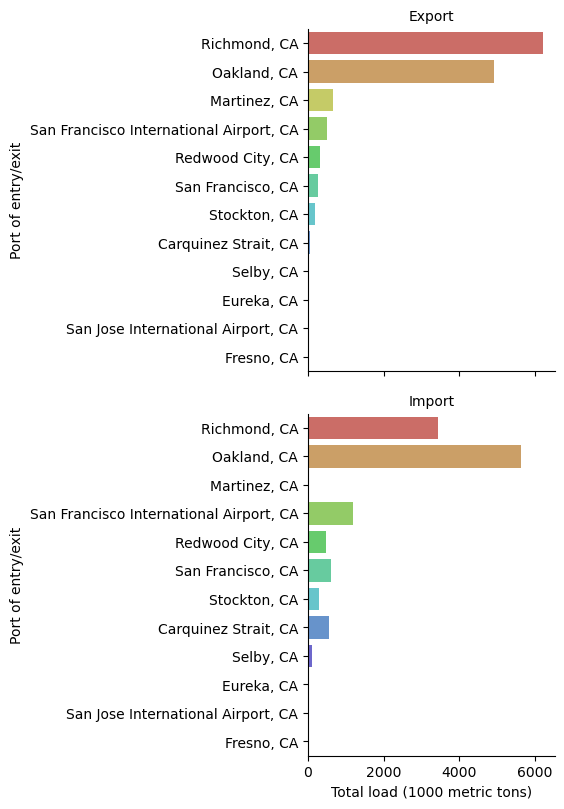

In [26]:
# total load
export_by_port = \
export_truck_shipment.groupby(['PORTID'])[['total_load']].sum()
export_by_port = export_by_port.reset_index()
export_by_port = \
export_by_port.sort_values(by = 'total_load', ascending = False)
export_by_port = export_by_port.head(10)
import_by_port = \
import_truck_shipment.groupby(['PORTID'])[['total_load']].sum()
import_by_port = import_by_port.reset_index()
import_by_port = \
import_by_port.sort_values(by = 'total_load', ascending = False)
import_by_port = import_by_port.head(10)

export_by_port.loc[:, 'Type'] = 'Export'
import_by_port.loc[:, 'Type'] = 'Import'

flow_by_port = pd.concat([export_by_port, import_by_port])


ax = sns.catplot( data = flow_by_port,
           y = 'PORTID', x = 'total_load', row = 'Type',
            palette = 'hls', kind = 'bar', height = 4, aspect = 0.8)
ax.set(ylabel ="Port of entry/exit")
ax.set(xlabel ="Total load (1000 metric tons)")
ax.set_titles("{row_name}")
plt.savefig(os.path.join(file_path, path_to_plot, 'regional_flow_by_port.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

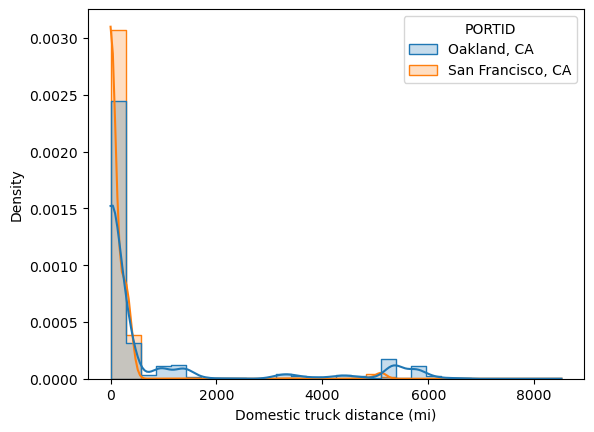

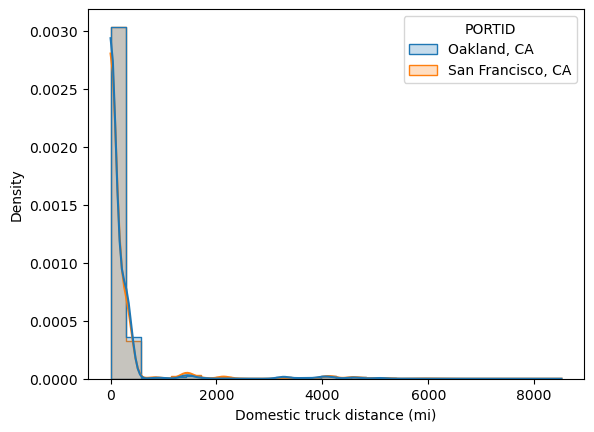

In [27]:
# plot shipment distance
sns.histplot(
   data=sf_import_truck_shipment, x="Distance", hue="PORTID", weights = 'total_load',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic truck distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_port_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

sns.histplot(
   data=sf_export_truck_shipment, x="Distance", hue="PORTID", weights = 'total_load',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic truck distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_port_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

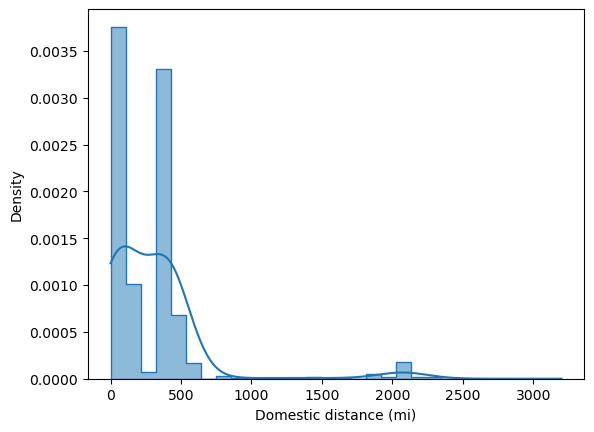

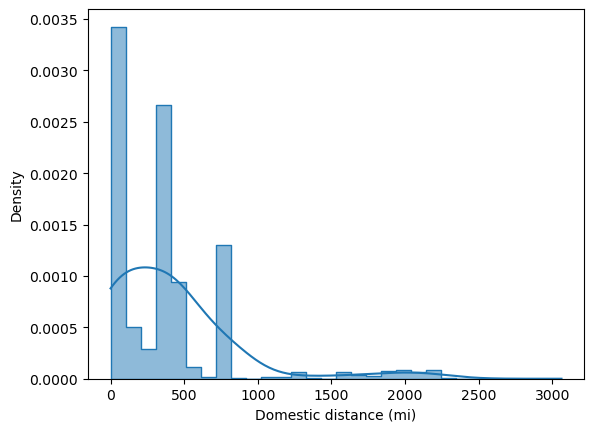

In [28]:
# plot reference shipment distance from faf
regional_import_truck = \
regional_import.loc[regional_import['mode_def'] == 'Truck']
sns.histplot(
   data=regional_import_truck, x="distance", weights = 'tons_2017',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'import_faf_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

regional_export_truck = \
regional_export.loc[regional_export['mode_def'] == 'Truck']
sns.histplot(
   data=regional_export_truck, x="distance", weights = 'tons_2017',
   common_norm=False, kde=True, element="step", bins = 30, stat = 'density',
)
plt.xlabel('Domestic distance (mi)')
plt.savefig(os.path.join(file_path, path_to_plot, 'export_faf_dist.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

In [29]:
regional_import.columns

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'value_2017', 'tmiles_2017', 'CFS_CODE', 'CFS_NAME', 'distance',
       'mode_def'],
      dtype='object')

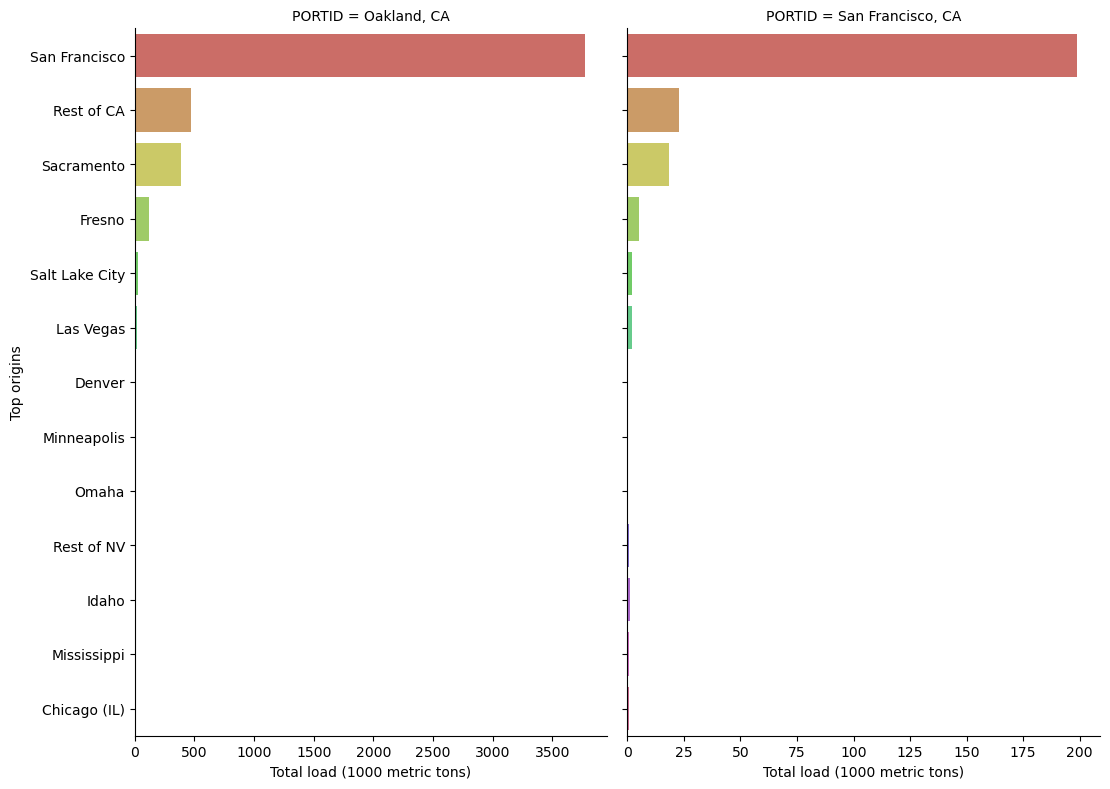

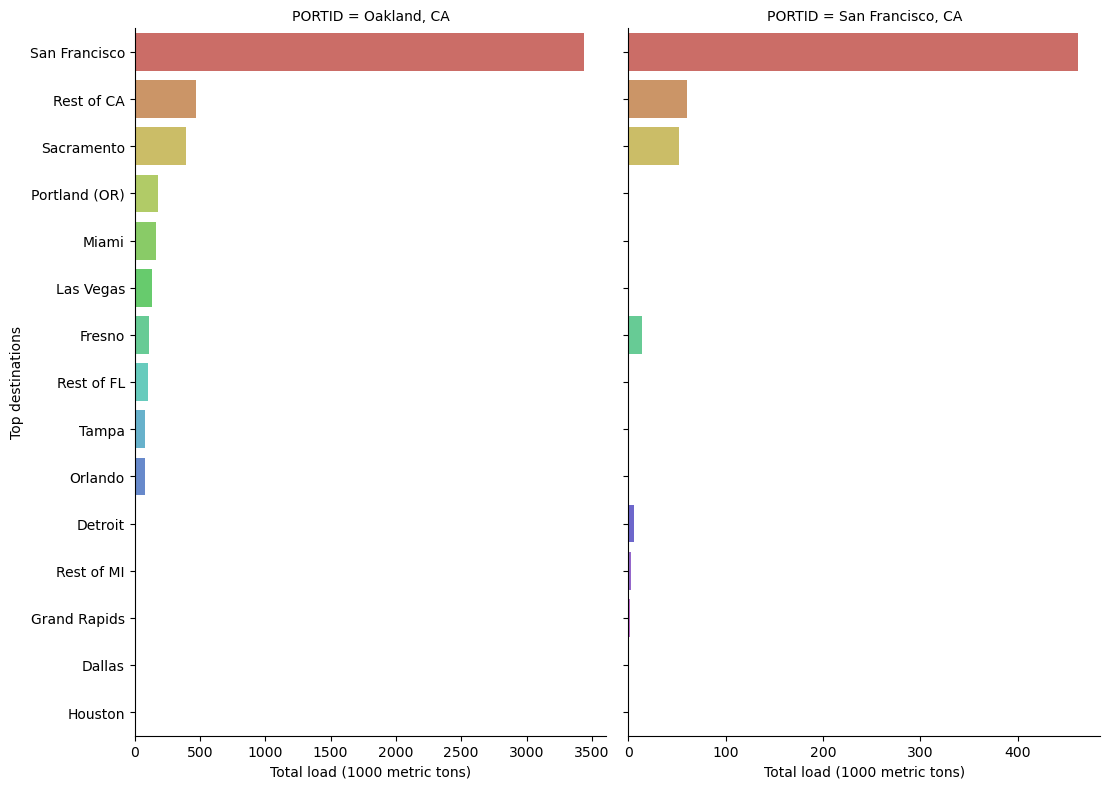

In [30]:
# top origin/destination
sf_export_truck_origin = \
sf_export_truck_shipment.groupby(['PORTID', 'FAFNAME'])[['total_load']].sum()
sf_export_truck_origin = sf_export_truck_origin.reset_index()
sf_export_truck_origin = \
sf_export_truck_origin.sort_values(by = 'total_load', ascending = False)

sf_import_truck_dest = \
sf_import_truck_shipment.groupby(['PORTID', 'FAFNAME'])[['total_load']].sum()
sf_import_truck_dest = sf_import_truck_dest.reset_index()
sf_import_truck_dest = \
sf_import_truck_dest.sort_values(by = 'total_load', ascending = False)

sf_import_truck_dest.head(5)

sf_export_truck_origin = sf_export_truck_origin.groupby('PORTID').head(10)
sf_export_truck_origin = sf_export_truck_origin.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_export_truck_origin,
           y = 'FAFNAME', x = 'total_load', col = 'PORTID', sharex = False,
                 height=8, aspect = 0.7, palette = 'hls')
ax.set(ylabel ="Top origins")
ax.set(xlabel ="Total load (1000 metric tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_port_orig.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()
sf_import_truck_dest = sf_import_truck_dest.groupby('PORTID').head(10)
sf_import_truck_dest = sf_import_truck_dest.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_import_truck_dest,
           y = 'FAFNAME', x = 'total_load', col = 'PORTID', sharex = False,
                 height=8, aspect = 0.7, palette = 'hls')
ax.set(ylabel ="Top destinations")
ax.set(xlabel ="Total load (1000 metric tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_port_dest.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

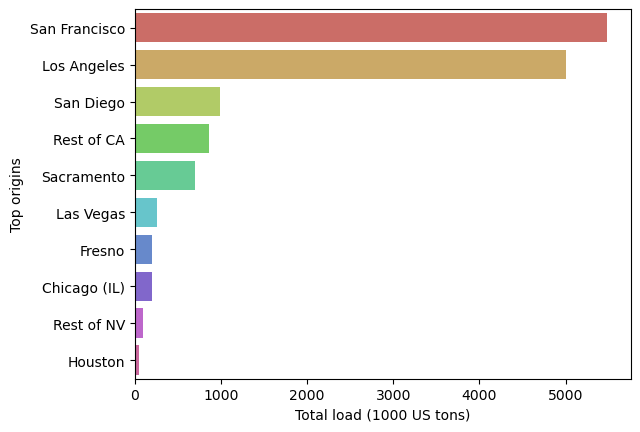

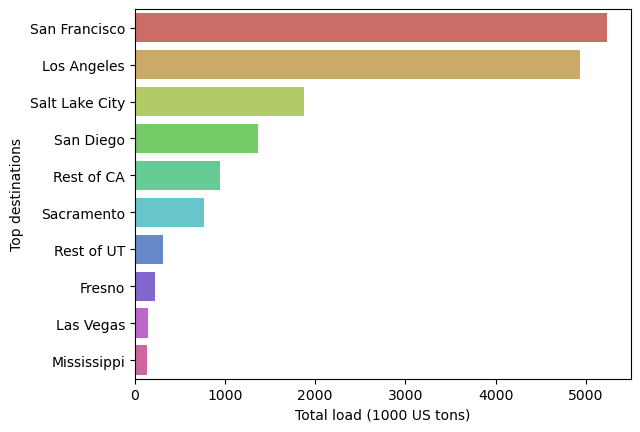

In [31]:
# plot reference faf top origin/destinations
faf_name_lookup['FAF'] = faf_name_lookup['FAF'].astype(int)
faf_export_truck_origin = \
regional_import_truck.groupby(['dms_dest'])[['tons_2017']].sum()
faf_export_truck_origin = faf_export_truck_origin.reset_index()
faf_export_truck_origin = pd.merge(faf_export_truck_origin, 
                                   faf_name_lookup,
                                   left_on = 'dms_dest', right_on = 'FAF',
                                   how = 'left')
faf_export_truck_origin = \
faf_export_truck_origin.sort_values(by = 'tons_2017', ascending = False)

faf_import_truck_dest = \
regional_export_truck.groupby(['dms_orig'])[['tons_2017']].sum()
faf_import_truck_dest = faf_import_truck_dest.reset_index()
faf_import_truck_dest = pd.merge(faf_import_truck_dest, 
                                   faf_name_lookup,
                                   left_on = 'dms_orig', right_on = 'FAF',
                                   how = 'left')
faf_import_truck_dest = \
faf_import_truck_dest.sort_values(by = 'tons_2017', ascending = False)

sf_import_truck_dest.head(5)

faf_export_truck_origin = faf_export_truck_origin.head(10)

ax = sns.barplot(data = faf_export_truck_origin,
           y = 'SHORTNAME', x = 'tons_2017',
           palette = 'hls')
ax.set(ylabel ="Top origins")
ax.set(xlabel ="Total load (1000 US tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'export_faf_orig.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

faf_import_truck_dest = faf_import_truck_dest.head(10)
ax = sns.barplot( data = faf_import_truck_dest,
           y = 'SHORTNAME', x = 'tons_2017',
            palette = 'hls')
ax.set(ylabel ="Top destinations")
ax.set(xlabel ="Total load (1000 US tons)")
plt.savefig(os.path.join(file_path, path_to_plot, 'import_faf_dest.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

In [32]:
faf_name_lookup.head(5)

,FAF,SHORTNAME
0,11,Birmingham
1,12,Mobile
2,19,Rest of AL
3,20,Alaska
4,41,Phoenix


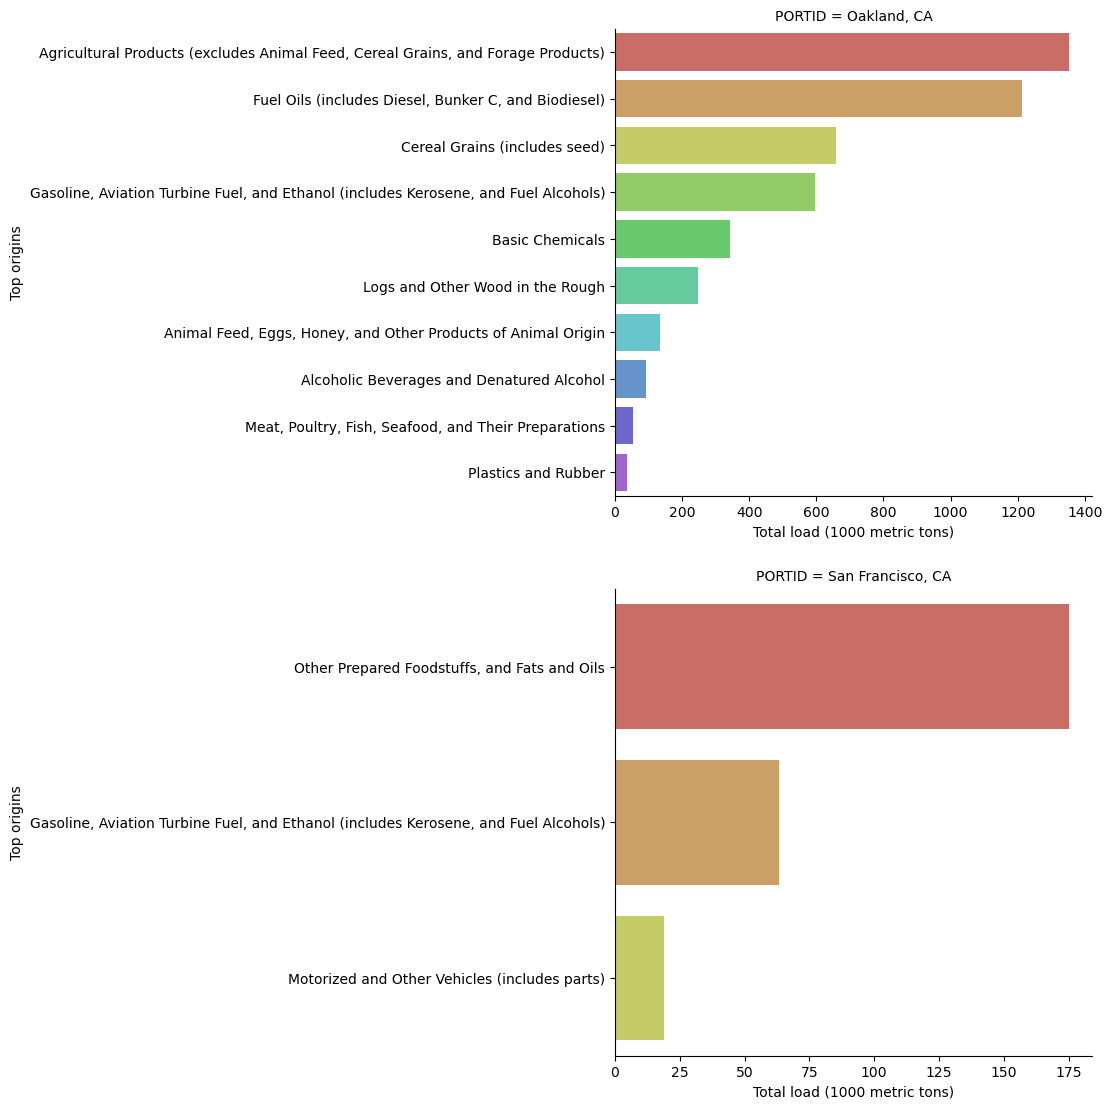

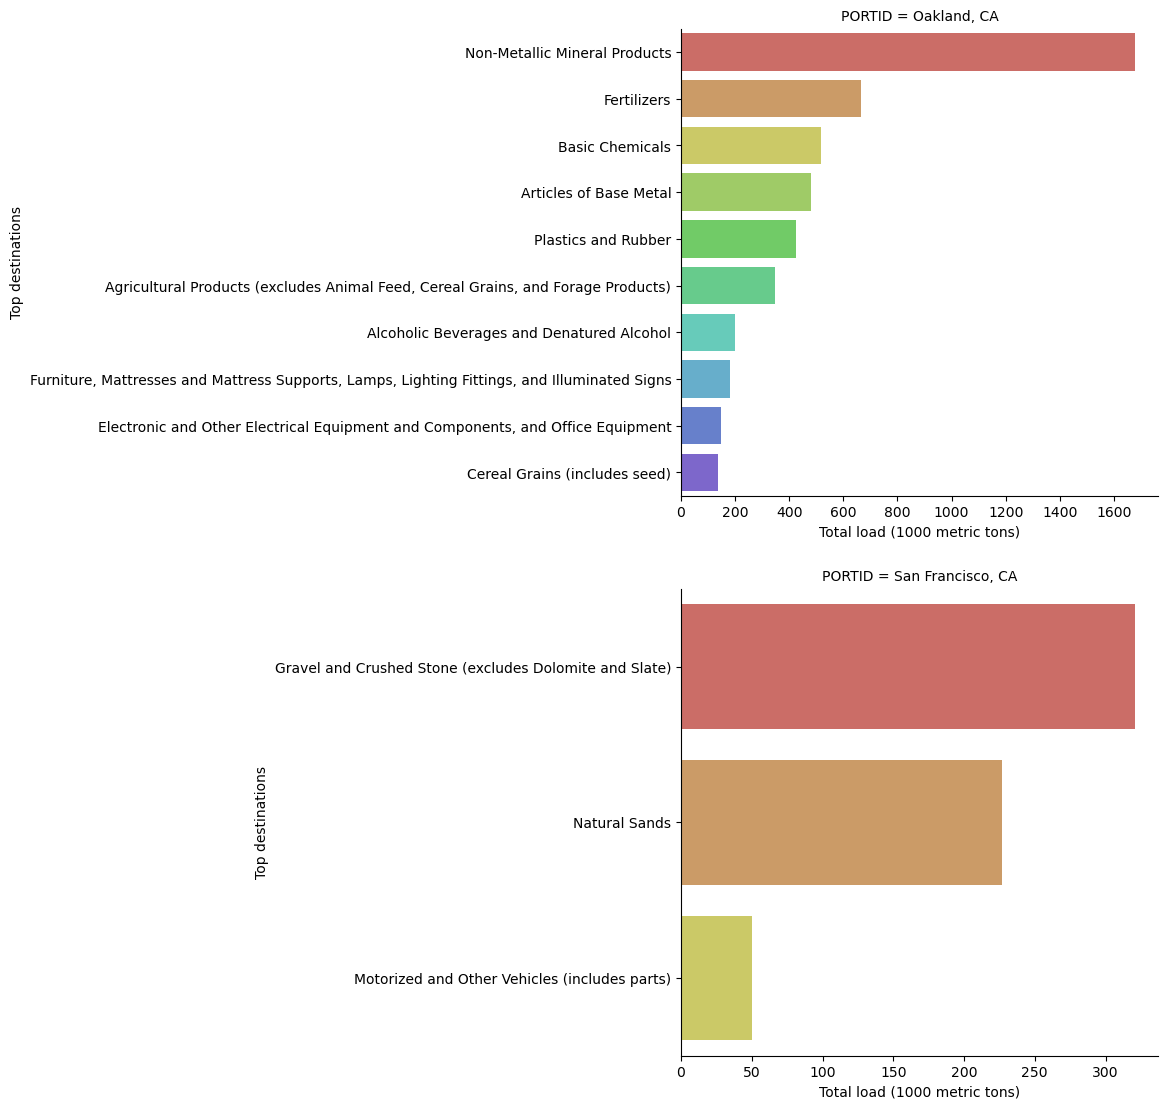

In [33]:
# top import/export commodity
sf_export_truck_sctg = \
sf_export_truck_shipment.groupby(['PORTID', 'Description'])[['total_load']].sum()
sf_export_truck_sctg = sf_export_truck_sctg.reset_index()
sf_export_truck_sctg = \
sf_export_truck_sctg.sort_values(by = 'total_load', ascending = False)

sf_import_truck_sctg = \
sf_import_truck_shipment.groupby(['PORTID', 'Description'])[['total_load']].sum()
sf_import_truck_sctg = sf_import_truck_sctg.reset_index()
sf_import_truck_sctg = \
sf_import_truck_sctg.sort_values(by = 'total_load', ascending = False)

sf_import_truck_sctg.head(5)

sf_export_truck_sctg = sf_export_truck_sctg.groupby('PORTID').head(10)
sf_export_truck_sctg = sf_export_truck_sctg.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_export_truck_sctg,
           y = 'Description', x = 'total_load', row = 'PORTID', sharex = False,
           sharey = False, height=5.5, aspect = 1, palette = 'hls')
ax.set(ylabel ="Top origins")
ax.set(xlabel ="Total load (1000 metric tons)")
plt.subplots_adjust(hspace = 0.2)
plt.savefig(os.path.join(file_path, path_to_plot, 'export_by_port_sctg.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()

sf_import_truck_sctg = sf_import_truck_sctg.groupby('PORTID').head(10)
sf_import_truck_sctg = sf_import_truck_sctg.reset_index()

ax = sns.catplot(kind = 'bar', data = sf_import_truck_sctg,
           y = 'Description', x = 'total_load', row = 'PORTID', sharex = False,
           sharey = False, height=5.5, aspect = 1, palette = 'hls')
ax.set(ylabel ="Top destinations")
ax.set(xlabel ="Total load (1000 metric tons)")
plt.subplots_adjust(hspace = 0.2)
plt.savefig(os.path.join(file_path, path_to_plot, 'import_by_port_sctg.png'),
           dpi = 300, bbox_inches = 'tight')
plt.show()